In [1]:
import scipy
from numpy import fft
import numpy as np
from numpy import linspace
import math
from scipy import integrate
from matplotlib import pyplot as plt

In [2]:
eps=np.finfo(float).eps

In [3]:
# numerical grid
n = 2**13                   # number of grid points
twidth = 12.5e-12          # width of time window [s]
c = 299792458              # speed of light [m/s]
wavelength = 835e-9        # reference wavelength [m]
w0 = (2*np.pi*c)/wavelength   # reference frequency [Hz]
dt = twidth/n
T = np.arange(-n/2, n/2-1)*dt # time grid

# === input pulse
power = 100                 # peak power of input [W]
t0 = 28.4e-15              # duration of input [s]
A = np.sqrt(power)*(1/(np.cosh(T/t0)))# input field [W^(1/2)]

# === fibre parameters
flength = 0.012             # fibre length [m]
# betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
betas = [-3.87856e-25,1.20677e-37,9.1831e-51]
gamma = 375.34              # nonlinear coefficient [1/W/m]
loss = 0                   # loss [dB/m]

# === Raman response
fr = 0.043                 # fractional Raman contribution
tau1 = 0.0122e-12; tau2 = 0.032e-12
RT = (tau1**2+tau2**2)/tau1/tau2**2*np.exp(-T/tau2)*np.sin(T/tau1)
RT = np.where(T < 0, RT, 0) # heaviside step function


# === simulation parameters
nsaves = 50     # number of length steps to save field at


In [4]:
n = len(T)
dT = T[1]-T[0]  # grid parameters
V = (np.arange(-n/2,n/2)*2*np.pi)/(n*dT)  # frequency grid
alpha = np.log(10**(loss/10))  # attenuation coefficient


B = 0
for i in range(len(betas)): # Taylor expansion of betas
    B += betas[i]/(math.factorial(i + 1)*V**(i + 1))
        
L = 1j*B - alpha /2  # linear operator

print(L)

[ 0.+1.88382567e-40j  0.+1.88428576e-40j  0.+1.88474607e-40j ...
 -0.-1.88520661e-40j -0.-1.88474607e-40j -0.-1.88428576e-40j]


In [5]:
# GNLSE Function
def gnlse(T, A, w0, gamma, betas, loss, fr, RT, flength, nsaves, printProgress = True):

    n = len(T)
    dT = T[1]-T[0]  # grid parameters
    V = (np.arange(-n/2,n/2)*2*np.pi)/(n*dT)  # frequency grid
    alpha = np.log(10**(loss/10))  # attenuation coefficient
    
    B = 0
    for i in range(len(betas)): # Taylor expansion of betas
        B += betas[i]/(math.factorial(i + 1)*V**(i + 1))
        
    L = 1j*B - alpha /2  # linear operator

    if abs(w0) > eps: # if w0>0 then include shock
        gamma = gamma/w0
        W=V+w0
    else: #set @ to 1 for no shock
        W = 1

    RW = n*fft.ifft(fft.fftshift(RT))  # frequency domain Raman
    L = fft.fftshift(L)
    W = fft.fftshift(W)  # shift to fft space

    def gnlse_rhs(z, AW):
        AT = fft.fft(AW*np.exp(L*z))  # time domain field
        AT = np.where(np.abs(AW) > eps, AW, 0)
        IT = np.abs(AT)**2  # time domain intensity
        if (len(RT) == 1) or fr < eps:  # no Raman case
            M = fft.ifft(AT*IT)  # response function
        else:
            RS = dT*fr*fft.fft(fft.ifft(IT)*RW)  # Raman convolution
            M = fft.ifft(AT*((1-fr)*IT+RS))  # response function

        R = 1j*gamma*W*M*np.exp(-L*z)  # full RHS of Eq. (3.13)
        

        return R

    # === setup and run the ODE integrator
    Z = np.linspace(0, flength, nsaves)# select output z points
    
    
    AW = np.zeros((nsaves, len(W)), dtype = 'complex_')# array for solution
    AW[0]=fft.fft(A)

    r = scipy.integrate.complex_ode(gnlse_rhs).set_integrator("dopri5")  # choice of method
    r.set_initial_value(fft.fft(A), 0) # initial values
    #help(r.integrate)
    for i in range(1, len(Z)):
        AW[i] = r.integrate(Z[i])  # get one more value, add it to the array
        if printProgress == True: 
            print(i , "/", len(Z))
        
        #AW.append(r.y)
        #if not r.successful():
        #    raise RuntimeError("Could not integrate")

    # === process output of integrator
    AT = []
    for i in range(len(AW)):
        AW[i] = AW[i] * np.exp(L*Z[i]) # change variables REMEMBER took ' out before Z
        AT.append(fft.ifft(AW[i]))           # time domain output
        AW[i] = fft.fftshift(AW[i])*dT*n  # scale

    W = V + w0  # the absolute frequency grid
    return {
            "AW" : AW, 
            "W" : W, 
            "AT": AT, 
            "Z" : Z
        }

In [6]:
# Multiple return values (tuple), explicitly unpack
#AW, W, AT = gnlse
# Multiple return values (tuple), keep tuple object, and index
#results = gnlse
#results[0] # AW
#results[1] # W
#results[2] # AT

In [7]:
# With dictonary
#results = gnlse
#results["AW"]

In [8]:
# propagate field
aaa = fft.fft(A)
results = gnlse(T, A, w0, gamma, betas, loss, fr, RT, flength, nsaves)


/var/folders/rs/4wwzr13n7gl2v6yf90jf926r0000gn/T/ipykernel_1321/2720096704.py:33: RuntimeWarning: overflow encountered in multiply
  M = fft.ifft(AT*((1-fr)*IT+RS))  # response function
/var/folders/rs/4wwzr13n7gl2v6yf90jf926r0000gn/T/ipykernel_1321/2720096704.py:28: RuntimeWarning: overflow encountered in square
  IT = np.abs(AT)**2  # time domain intensity
/var/folders/rs/4wwzr13n7gl2v6yf90jf926r0000gn/T/ipykernel_1321/2720096704.py:33: RuntimeWarning: invalid value encountered in multiply
  M = fft.ifft(AT*((1-fr)*IT+RS))  # response function
/Users/pablobedoyarios/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_ode.py:1181: UserWarning: dopri5: larger nsteps is needed
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


1 / 50


/Users/pablobedoyarios/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_ode.py:1181: UserWarning: dopri5: step size becomes too small
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


2 / 50
3 / 50
4 / 50
5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50


In [9]:
print("AW:", results["AW"][25], "A0: ", aaa)

AW: [ 0.00095834-0.00018868j -0.00043448-0.00030984j  0.00097953-0.00028682j
 ... -0.00816157-0.00597656j  0.02028166-0.00213909j
 -0.00039785-0.00029025j] A0:  [ 584.72026185-1.33226763e-15j -584.57320803+2.24208398e-01j
  584.13241607-4.48078737e-01j ... -583.3989923 -6.71274373e-01j
  584.13241607+4.48078737e-01j -584.57320803-2.24208398e-01j]


In [10]:
def compareArrays(a,b):
    arraysEqual = True
    for i in range(len(a)):
        if (a[i] - b[i]) > eps:
            arraysEqual = False
            print("Not equal value found at element ", i, a[i], b[i])
    if arraysEqual == True:
        print("The arrays are equal")
        
compareArrays(results["AW"][0],results["AW"][49])
            

Not equal value found at element  1 (4.549459152733394e-25-3.771689361403205e-25j) (-0.0004344799093324948-0.00030983722580116366j)
Not equal value found at element  3 (9.93501933224745e-26-5.7348690492636675e-25j) (-0.00047957613889837284-0.00032827278022247295j)
Not equal value found at element  5 (3.8301461880187003e-25-4.793709465706827e-25j) (-0.0005318381267448594-0.00034343847390323686j)
Not equal value found at element  7 (2.890677045624107e-25-4.302092630746847e-25j) (-0.0005894625467261966-0.00035307288294856437j)
Not equal value found at element  9 (3.029259281487256e-26-3.246582249853558e-26j) (-0.0006502578124053257-0.00035500982685630845j)
Not equal value found at element  11 (-2.506019471115701e-25+9.524823671857356e-26j) (-0.0007118220171836064-0.00034741519155135844j)
Not equal value found at element  13 (1.0997631359279007e-25-5.884662635473905e-26j) (-0.0007717259436134724-0.00032897858052003786j)
Not equal value found at element  15 (-7.854856213649362e-26-2.5287875

Not equal value found at element  736 (-3.1779854707357565e-27+2.700957833868964e-25j) (-3.5172273994135216e-05-4.7756114712617906e-05j)
Not equal value found at element  738 (2.113612346077397e-25-4.6905865367979147e-26j) (-3.514910228504989e-05-4.772243511637321e-05j)
Not equal value found at element  740 (7.215758912238715e-27+1.149723928246577e-25j) (-3.512640766531036e-05-4.768846716943441e-05j)
Not equal value found at element  742 (-4.0147951657197984e-25-3.177943488718399e-25j) (-3.5104183886754275e-05-4.7654221069149445e-05j)
Not equal value found at element  744 (-3.034343864339312e-25-1.7430073490394075e-25j) (-3.508242484296213e-05-4.761970671508109e-05j)
Not equal value found at element  746 (3.5223971452078254e-26+4.453416636217314e-25j) (-3.506112456409665e-05-4.758493372107424e-05j)
Not equal value found at element  748 (3.3285705850898427e-25+3.0732649405255594e-25j) (-3.5040277211632674e-05-4.754991142649884e-05j)
Not equal value found at element  750 (9.8193333250669

Not equal value found at element  1272 (3.569169038113596e-25-2.221665209152596e-25j) (-3.7098006910607404e-05-3.80280863281939e-05j)
Not equal value found at element  1274 (-1.4631929308104224e-25-3.9961287757184037e-25j) (-3.71198622427285e-05-3.7997310567232334e-05j)
Not equal value found at element  1276 (-1.3939813332114543e-25+1.4521314317108727e-25j) (-3.7141774083227167e-05-3.796657853821575e-05j)
Not equal value found at element  1278 (-1.4798624238634628e-26+6.863008103718355e-27j) (-3.716374222413549e-05-3.79358901412586e-05j)
Not equal value found at element  1280 (-9.006390756503947e-26-1.4292051319782544e-25j) (-3.718576646021157e-05-3.790524527662362e-05j)
Not equal value found at element  1282 (-1.3544411275451872e-25-8.514708952985262e-26j) (-3.7207846588915675e-05-3.787464384472962e-05j)
Not equal value found at element  1284 (1.1989344619365398e-26+1.5906917141807957e-25j) (-3.722998241038554e-05-3.78440857461583e-05j)
Not equal value found at element  1286 (2.131939

Not equal value found at element  1772 (-7.67317901496461e-26+3.506533721060223e-25j) (-4.409493790287276e-05-3.148503283087349e-05j)
Not equal value found at element  1774 (-3.966747189854215e-26+3.1658779362575364e-26j) (-4.412913742747939e-05-3.1462860507635455e-05j)
Not equal value found at element  1776 (-1.8623306463347318e-25+7.002334649639658e-26j) (-4.416339282789211e-05-3.144071653214348e-05j)
Not equal value found at element  1778 (4.331518228133718e-26+1.6312491867086638e-25j) (-4.4197704244276316e-05-3.141860087903288e-05j)
Not equal value found at element  1780 (-3.5680347455690815e-26+2.1090065677213948e-26j) (-4.423207181777271e-05-3.1396513523144434e-05j)
Not equal value found at element  1782 (-1.7495546703546834e-25+2.617670977561077e-25j) (-4.426649569049138e-05-3.137445443953214e-05j)
Not equal value found at element  1784 (1.7413645288247406e-25+7.341558269983835e-26j) (-4.430097600551613e-05-3.1352423603451857e-05j)
Not equal value found at element  1786 (-1.3818

Not equal value found at element  2270 (-1.3682786812887952e-25-3.840495557346153e-25j) (-5.485928530491415e-05-2.6800662712224535e-05j)
Not equal value found at element  2272 (-8.547304984947144e-26+1.3064164713546463e-25j) (-5.4914548911853996e-05-2.678515793112945e-05j)
Not equal value found at element  2274 (-3.206160774664499e-25-3.0521006045308056e-29j) (-5.496994011890501e-05-2.6769679418025235e-05j)
Not equal value found at element  2276 (6.306828964067668e-26-2.177633787830213e-25j) (-5.502545941432646e-05-2.6754227173425218e-05j)
Not equal value found at element  2278 (-2.5066355680041967e-25+2.0278674669566563e-25j) (-5.5081107288623674e-05-2.6738801197849165e-05j)
Not equal value found at element  2280 (-2.3644100384560488e-25-2.035611579882035e-25j) (-5.513688423456472e-05-2.6723401491820982e-05j)
Not equal value found at element  2282 (-1.5190780861201697e-25+2.011430273178287e-25j) (-5.5192790747188245e-05-2.6708028055866345e-05j)
Not equal value found at element  2284 (

Not equal value found at element  2770 (-1.5885991090075592e-21-8.850074708796828e-22j) (-7.438389184912292e-05-2.3735388973039825e-05j)
Not equal value found at element  2772 (-1.662503875199555e-21-9.239820395333353e-22j) (-7.449474202181314e-05-2.3726287758076007e-05j)
Not equal value found at element  2774 (-1.7393465846536348e-21-9.654133787992247e-22j) (-7.460596085406249e-05-2.371720957949303e-05j)
Not equal value found at element  2776 (-1.819605722659232e-21-1.008086825849058e-21j) (-7.471755011273277e-05-2.3708154386048956e-05j)
Not equal value found at element  2778 (-1.9037986000453893e-21-1.0529561945640533e-21j) (-7.482951157520857e-05-2.3699122125835382e-05j)
Not equal value found at element  2780 (-1.9920861924887543e-21-1.0995584663461074e-21j) (-7.49418470294773e-05-2.3690112746275202e-05j)
Not equal value found at element  2782 (-2.0845618741372113e-21-1.1484435664134708e-21j) (-7.505455827420863e-05-2.3681126194108107e-05j)
Not equal value found at element  2784 (-2

Not equal value found at element  3270 (-1.2807716785631e-16-4.193545382785886e-17j) (-0.00012071712406384026-2.1815699407957264e-05j)
Not equal value found at element  3272 (-1.3398619196134983e-16-4.37564378295191e-17j) (-0.00012102308930626732-2.180601815828767e-05j)
Not equal value found at element  3274 (-1.4016774606809484e-16-4.5656216380022787e-17j) (-0.00012133058739858499-2.1796260509254393e-05j)
Not equal value found at element  3276 (-1.4663439503419276e-16-4.763818568991336e-17j) (-0.00012163962887751187-2.178642493801092e-05j)
Not equal value found at element  3278 (-1.5339928393381339e-16-4.970588693481731e-17j) (-0.00012195022436372666-2.177650989918643e-05j)
Not equal value found at element  3280 (-1.6047616261270049e-16-5.186301423100451e-17j) (-0.00012226238456228118-2.1766513825116825e-05j)
Not equal value found at element  3282 (-1.67879414956317e-16-5.411341987016248e-17j) (-0.00012257612026303027-2.1756435126125614e-05j)
Not equal value found at element  3284 (-1

Not equal value found at element  3770 (-9.909481818331899e-12-1.2416659927768483e-12j) (-0.00020050633685567932+2.054666282626178e-05j)
Not equal value found at element  3772 (-1.0365062641592624e-11-1.290675703563684e-12j) (-0.00019922930426766758+1.986839787471599e-05j)
Not equal value found at element  3774 (-1.0841581920760644e-11-1.3415681656833424e-12j) (-0.00019796006928860196+1.9052543782791057e-05j)
Not equal value found at element  3776 (-1.1340001682437512e-11-1.3944129485857954e-12j) (-0.0001966997651397852+1.8106170037230507e-05j)
Not equal value found at element  3778 (-1.1861328139449094e-11-1.4492820411790223e-12j) (-0.00019545043960097556+1.7037680626441542e-05j)
Not equal value found at element  3780 (-1.2406613719579073e-11-1.5062499273516514e-12j) (-0.00019421651258007613+1.58567602682337e-05j)
Not equal value found at element  3782 (-1.2976959187398979e-11-1.5653936633274243e-12j) (-0.000193006383100817+1.4574470698236757e-05j)
Not equal value found at element  37

Not equal value found at element  4179 (2.170473389774366e-09-6.995149431103958e-11j) (-0.00037054743236413786-0.00738672094132157j)
Not equal value found at element  4180 (-2.1244171293536583e-09+6.928282146725179e-11j) (-0.002807195017679697-0.002352015504455915j)
Not equal value found at element  4181 (2.0792493739919266e-09-6.860812005873133e-11j) (-0.0005838882710806001-0.007084941725293436j)
Not equal value found at element  4182 (-2.0349586898554716e-09+6.792803078422166e-11j) (-0.0029833477085726423-0.0019235668479472422j)
Not equal value found at element  4183 (1.9915333989659112e-09-6.724316856940395e-11j) (-0.0007600985459619791-0.006723857993661014j)
Not equal value found at element  4184 (-1.9489616128868506e-09+6.655412324837484e-11j) (-0.003081147455899133-0.001468166548239591j)
Not equal value found at element  4185 (1.9072312642326427e-09-6.586146024746677e-11j) (-0.0008872632839949854-0.006312689491758029j)
Not equal value found at element  4186 (-1.8663301361011072e-

Not equal value found at element  4621 (1.0785902202387623e-13-2.2059910228068087e-14j) (-2.476297046833309e-05-8.936322173041726e-05j)
Not equal value found at element  4623 (1.03111906616099e-13-2.117142158306277e-14j) (-2.7035844174938036e-05-8.612012709546464e-05j)
Not equal value found at element  4625 (9.857366186642433e-14-2.031842230401226e-14j) (-2.9291292321001282e-05-8.296941895916585e-05j)
Not equal value found at element  4627 (9.423510021464627e-14-1.9499508942365897e-14j) (-3.152774921725777e-05-7.990867633308758e-05j)
Not equal value found at element  4629 (9.008743811763034e-14-1.8713332869572795e-14j) (-3.374384585160683e-05-7.693553992255279e-05j)
Not equal value found at element  4631 (8.612227828699523e-14-1.7958598168398797e-14j) (-3.5938379661566895e-05-7.404770211913303e-05j)
Not equal value found at element  4633 (8.233159270890881e-14-1.723405960525759e-14j) (-3.811028743881651e-05-7.124290014400841e-05j)
Not equal value found at element  4635 (7.8707706407722

Not equal value found at element  5121 (1.3720676896721577e-18-5.69639715722653e-19j) (-0.0001504437856180937+3.878162485301324e-05j)
Not equal value found at element  5123 (1.311468116555639e-18-5.456600752118552e-19j) (-0.00015042136661488198+3.884726603180478e-05j)
Not equal value found at element  5125 (1.2535447084596174e-18-5.226888287457673e-19j) (-0.00015039861828523125+3.8912947084946346e-05j)
Not equal value found at element  5127 (1.1981772143138912e-18-5.006819292327029e-19j) (-0.0001503755489382478+3.89786716775166e-05j)
Not equal value found at element  5129 (1.1452550593869968e-18-4.7959901499564e-19j) (-0.00015035216673872436+3.90444433947081e-05j)
Not equal value found at element  5131 (1.0946707484732534e-18-4.594024729364778e-19j) (-0.00015032847970969875+3.911026574366716e-05j)
Not equal value found at element  5133 (1.046319053542935e-18-4.400551569232393e-19j) (-0.00015030449573496727+3.917614215528988e-05j)
Not equal value found at element  5135 (1.00010214322811

Not equal value found at element  5565 (5.933995075250951e-23-3.764600826655454e-23j) (-0.00014451630521251498+5.716744021761933e-05j)
Not equal value found at element  5567 (5.662056616984178e-23-3.611529937429441e-23j) (-0.00014449883221184985+5.7272901912722596e-05j)
Not equal value found at element  5569 (5.394468288014014e-23-3.436291114575323e-23j) (-0.0001444814772241414+5.737858803973577e-05j)
Not equal value found at element  5571 (5.152541952818738e-23-3.3245488109862464e-23j) (-0.00014446424018533423+5.748449880083337e-05j)
Not equal value found at element  5573 (4.942239543939337e-23-3.1479287699681585e-23j) (-0.00014444712102781304+5.7590634398881635e-05j)
Not equal value found at element  5575 (4.718041245010092e-23-3.034272254661567e-23j) (-0.00014443011968047042+5.76969950374558e-05j)
Not equal value found at element  5577 (4.508704742964725e-23-2.909214105448508e-23j) (-0.00014441323606876477+5.780358092085826e-05j)
Not equal value found at element  5579 (4.31887680018

Not equal value found at element  5901 (-1.1143714286993691e-25-1.6827708876554893e-25j) (-0.0001431204112966069+7.822750746500189e-05j)
Not equal value found at element  5903 (1.377428905367298e-25+4.106293402705424e-27j) (-0.00014312046914000644+7.837448509651202e-05j)
Not equal value found at element  5905 (-2.618114252862784e-25-1.0568459211119931e-25j) (-0.00014312061445574402+7.852174078516668e-05j)
Not equal value found at element  5907 (2.425609138550167e-25+1.330839767384338e-25j) (-0.00014312084704937275+7.866927501368696e-05j)
Not equal value found at element  5909 (2.677312436337942e-25-3.007054716091641e-25j) (-0.00014312116672699927+7.881708826720905e-05j)
Not equal value found at element  5911 (9.764591382316839e-26+1.4376408344582097e-25j) (-0.00014312157329528837+7.896518103331474e-05j)
Not equal value found at element  5913 (3.4923790722279795e-25-2.21914535741839e-25j) (-0.00014312206656147948+7.911355380202448e-05j)
Not equal value found at element  5915 (-1.2006300

Not equal value found at element  6183 (-1.5899717841054988e-25-1.833469610664126e-25j) (-0.0001439141096321671+0.00010195950976362017j)
Not equal value found at element  6185 (1.9273355369793887e-25+2.7288632603023995e-25j) (-0.00014392491945445222+0.00010215174450296694j)
Not equal value found at element  6187 (-3.1505143266267126e-25-4.459491481894963e-25j) (-0.00014393579715569257+0.00010234435469698929j)
Not equal value found at element  6189 (-4.1964609851617826e-26+2.244526983985883e-25j) (-0.000143946742668132+0.00010253734129675067j)
Not equal value found at element  6191 (-2.338461072179698e-25-5.356102316437415e-26j) (-0.00014395775592523967+0.00010273070525785513j)
Not equal value found at element  6193 (3.3543417951443517e-25+1.1163614630920287e-25j) (-0.00014396883686169305+0.00010292444754049172j)
Not equal value found at element  6195 (-4.185790814885729e-25-6.128974278866588e-25j) (-0.00014397998541341013+0.00010311856910944056j)
Not equal value found at element  6197 

Not equal value found at element  6537 (-5.051604031454746e-25+3.2726266547110344e-25j) (-0.00014688006404227957+0.00014291710382462457j)
Not equal value found at element  6539 (1.6815879662109068e-25-5.435941654781071e-26j) (-0.00014690320884412603+0.00014319595690335493j)
Not equal value found at element  6541 (3.656869848122396e-27+7.281375990528669e-26j) (-0.00014692643529916043+0.0001434754547922724j)
Not equal value found at element  6543 (-1.8285180718697136e-26-5.293276745034007e-25j) (-0.00014694974369172081+0.00014375559983575054j)
Not equal value found at element  6545 (3.593375925167598e-25-3.496316181799055e-27j) (-0.000146973134309473+0.0001440363943913239j)
Not equal value found at element  6547 (-4.83975186196982e-25-1.4521306038454497e-25j) (-0.00014699660744343782+0.00014431784082977035j)
Not equal value found at element  6549 (1.2708892815319372e-25-1.8094656674606988e-25j) (-0.00014702016338801583+0.00014459994153521213j)
Not equal value found at element  6551 (-1.2

Not equal value found at element  6953 (-8.848055366671056e-26-3.619340708271732e-25j) (-0.00015424263454742368+0.00021966663710733977j)
Not equal value found at element  6955 (1.8865622350526203e-25+9.15579387068581e-26j) (-0.000154297008667858+0.00022016031577939187j)
Not equal value found at element  6957 (-3.5144692480617307e-25+3.8292387876750073e-25j) (-0.00015435166836115456+0.00022065565024009383j)
Not equal value found at element  6959 (-3.6710475914777966e-25-3.708171957526499e-25j) (-0.00015440661599212287+0.00022115264994865063j)
Not equal value found at element  6961 (2.500011537218883e-25-5.930950194515688e-26j) (-0.00015446185395106608+0.00022165132444278203j)
Not equal value found at element  6963 (-2.8402694704237743e-25+7.420213573980681e-25j) (-0.00015451738465410434+0.00022215168333956318j)
Not equal value found at element  6965 (-5.90721439969582e-25-3.103253081176084e-25j) (-0.00015457321054350548+0.00022265373633629333j)
Not equal value found at element  6967 (2.

Not equal value found at element  7215 (3.4838636485618796e-26-2.3059785247362073e-25j) (-0.00016510290971706793+0.00030317432397850404j)
Not equal value found at element  7217 (-7.777710289282775e-26+2.8177492105748954e-25j) (-0.00016523027841944168+0.00030400928557783964j)
Not equal value found at element  7219 (-1.3960005155645805e-25+3.47111319501217e-25j) (-0.00016535868148065074+0.00030484834470782926j)
Not equal value found at element  7221 (-9.761548711542732e-26-1.6653807665505905e-25j) (-0.00016548813126696657+0.0003056915364745305j)
Not equal value found at element  7223 (4.9559223084399893e-26-4.7810088462812245e-25j) (-0.00016561864033721492+0.0003065388964190682j)
Not equal value found at element  7225 (-4.043303212503645e-26+4.716338347428521e-25j) (-0.00016575022144654572+0.00030739046052465335j)
Not equal value found at element  7227 (-2.91265442874131e-25+4.348754960118666e-25j) (-0.0001658828875502749+0.0003082462652237507j)
Not equal value found at element  7229 (-5

Not equal value found at element  7619 (6.430297499410838e-27-1.7937725803295044e-25j) (-0.00028152055037077765+0.0006800358817461461j)
Not equal value found at element  7621 (1.0928533397391239e-25+1.1665115879163426e-25j) (-0.00028383884441496077+0.0006845287913022364j)
Not equal value found at element  7623 (-4.177822177421432e-25+1.8858071943482503e-26j) (-0.0002862124797407605+0.0006890806177064309j)
Not equal value found at element  7625 (-4.979905148788218e-25-4.986297779904911e-25j) (-0.00028864254626122704+0.0006936915246439809j)
Not equal value found at element  7627 (-2.786861570732243e-25-3.3566739040809858e-25j) (-0.00029113018975617465+0.0006983614976951662j)
Not equal value found at element  7629 (1.561191716086294e-25-5.229050100077316e-25j) (-0.0002936766435625291+0.0007030903363349472j)
Not equal value found at element  7631 (1.526138861893437e-25-1.755937454382815e-25j) (-0.0002962832629463275+0.00070787765269913j)
Not equal value found at element  7633 (6.4536686258

Not equal value found at element  7904 (2.0849589490093385e-26-1.5536326265758082e-25j) (-0.002033126308547741-0.0005671733041956187j)
Not equal value found at element  7905 (2.9719967421937564e-26+3.790775334364494e-25j) (-0.004201060739091135+0.0007446865707413373j)
Not equal value found at element  7906 (-1.529204596228878e-26-1.7256870244028533e-25j) (-0.002102718903614346-0.0006254609156985908j)
Not equal value found at element  7907 (5.911204111890096e-26+3.947156511397226e-25j) (-0.004353730519344096+0.0007233112815818054j)
Not equal value found at element  7908 (1.2605028476837146e-25-1.175216241691644e-25j) (-0.0021774221306697385-0.0006834044778843204j)
Not equal value found at element  7909 (8.274021673475427e-26+2.2119438164804503e-25j) (-0.004510351925554089+0.0007078695848569578j)
Not equal value found at element  7910 (3.318031932201182e-25-4.32521733835916e-26j) (-0.002256619957290689-0.000739974189848837j)
Not equal value found at element  7911 (1.344374173166429e-25+4

Not equal value found at element  8067 (1.0837072141642167e-25-6.716397492776401e-26j) (-0.0009430381388294337+0.007835110345573142j)
Not equal value found at element  8068 (2.6058325307685987e-26+7.707902279311454e-26j) (-0.006736237933703592-0.011109010776540904j)
Not equal value found at element  8069 (-1.3030264665515818e-25+4.549498689039144e-26j) (-0.000301291914195284+0.007698087235184826j)
Not equal value found at element  8070 (-1.290204280628512e-25-1.312861181132205e-25j) (-0.006786615980553241-0.010785705017576785j)
Not equal value found at element  8072 (3.0815612344084734e-25+1.1564545985884925e-25j) (-0.006809465813529728-0.010433670667958693j)
Not equal value found at element  8074 (-2.983972280525e-25-1.4484428139848212e-25j) (-0.006806148103139023-0.010064688247940363j)
Not equal value found at element  8076 (2.003352199093742e-25-8.819830334857514e-26j) (-0.006778354278093368-0.009690585098893157j)
Not equal value found at element  8078 (2.4406696025097073e-26+1.8483

In [11]:
frequencies = results["W"]


In [12]:
finalAWConjugate = np.abs(results["AW"][nsaves - 1]) ** 2

In [13]:
AConjugate = np.abs(fft.ifft(fft.fftshift(A)))**2 

In [14]:
def toDecibles(from_):
    return 10 * np.log10(from_)

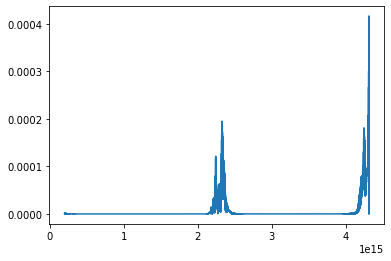

In [15]:
plt.plot(frequencies, finalAWConjugate)

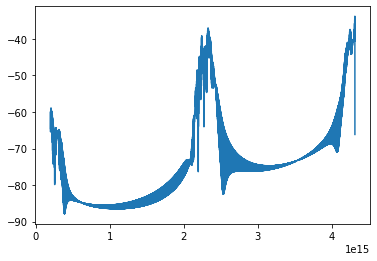

In [16]:
plt.plot(frequencies, toDecibles(finalAWConjugate))

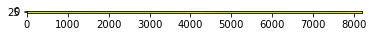

In [17]:
plt.imshow(toDecibles(np.abs(results["AW"]) ** 2))